# Distributions test

This file will be to test the distributions package I've written, to make sure that the classes work as expected and produce reasonable values

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import Profiles
import Distributions

In [2]:
zmax = 70e3
dz = 100

z = np.arange(dz,zmax,dz)

T,p,rho = Profiles.Isothermal_hydrostatic(z)

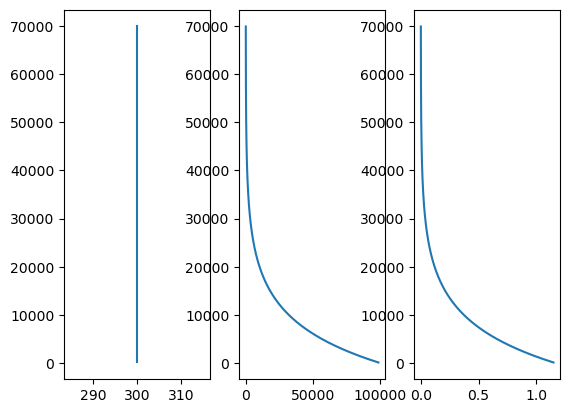

In [3]:
fig = plt.figure()
data = [T,p,rho]

for i,d in enumerate(data):
    ax = fig.add_subplot(1,len(data),i+1)
    ax.plot(data[i],z)

plt.show()

## Testing Grey Gas

This test will be for a singular grey gas. Just to test if the extinction seems to be following the correct trend with respect to the atmosphere (should simply be a scaling of rho)

In [4]:
lambdas = [770e-9] # (m) the wavelengths we want to consider for our simulation. The units don't matter too much currently

# This will be to create a grey gas background, no spectral resolution required.
cs_sca = 1e-32 # (m^2) scattering cross-section
cs_abs = 0.5e-32 # (m^2) absorption cross-section
cs = np.array([cs_sca,cs_abs]).reshape((2,1))

m_bar = 28.964 * 1.66e-27 # (kg) the average mass of the air particles in our grey gas   #28.964 g/mol
n_z = rho / m_bar

GG = Distributions.GreyGas(n_z,cs,1)

print(GG.csSca)
print(GG.csExt)

[[1.e-32]]
[[1.5e-32]]


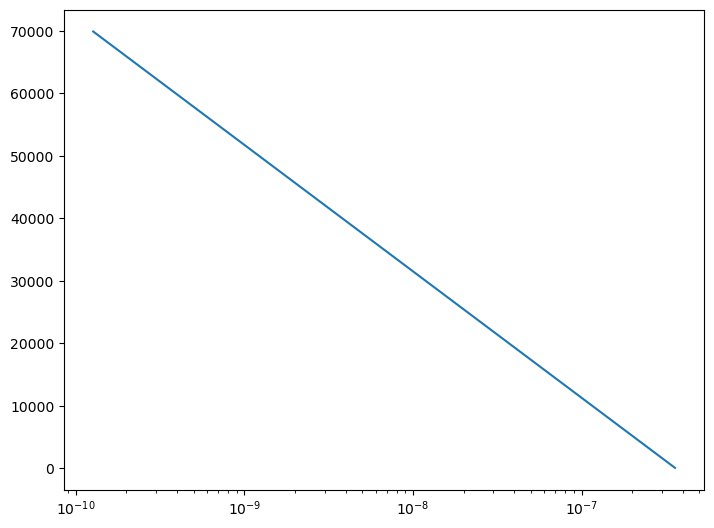

In [5]:
fig = plt.figure()

ax = fig.add_axes((0,0,1,1))

for i,l in enumerate(lambdas):
    # for each wavelength, plot the extinction as a function of height
    betaZ = GG.n_z * GG.csExt[i,i]
    ax.plot(betaZ,z)

ax.set_xscale('log')

plt.show()

## Testing a multi-wavelength absorber

This will be a gas that interacts in 3 wavelengths. Thus, we should see 3 seperate beta profiles that are seperated by a constant offset in a logarithmic plot.

In [6]:
lambdas = [500e-9,770e-9,1000e-9] # (m) the wavelengths we want to consider for our simulation. The units don't matter too much currently

# The cross sections for the different wavelengths
cs_sca = [0.5e-32,1e-32,1.5e-32] # (m^2) scattering cross-sections for each lambda
cs_abs = [0.5e-32,0.5e-32,0.5e-32]# (m^2) absorption cross-section for each lambda
cs = np.array([cs_sca,cs_abs])

print(cs)

m_bar = 28.964 * 1.66e-27 # (kg) the average mass of the air particles in our grey gas   #28.964 g/mol
n_z = rho / m_bar

MultiDist = Distributions.Base(n_z,cs)

print(MultiDist.csSca)
print(MultiDist.csExt)

[[5.0e-33 1.0e-32 1.5e-32]
 [5.0e-33 5.0e-33 5.0e-33]]
[[5.0e-33 0.0e+00 0.0e+00]
 [0.0e+00 1.0e-32 0.0e+00]
 [0.0e+00 0.0e+00 1.5e-32]]
[[1.0e-32 0.0e+00 0.0e+00]
 [0.0e+00 1.5e-32 0.0e+00]
 [0.0e+00 0.0e+00 2.0e-32]]


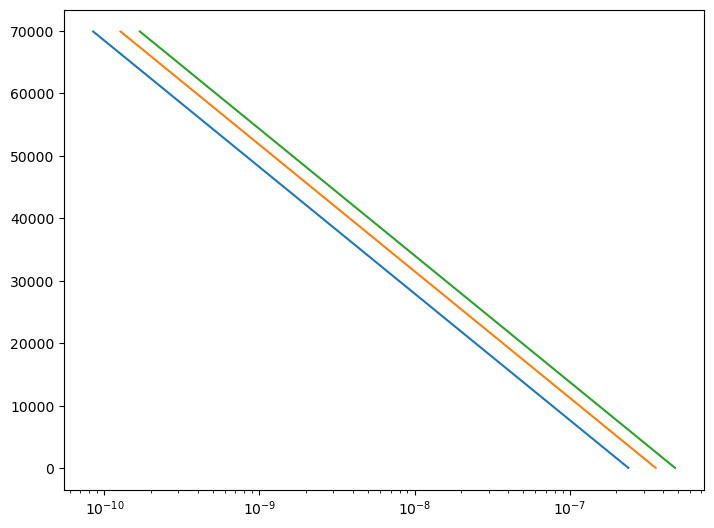

In [7]:
fig = plt.figure()

ax = fig.add_axes((0,0,1,1))

for i,l in enumerate(lambdas):
    # for each wavelength, plot the extinction as a function of height
    betaZ = MultiDist.n_z * MultiDist.csExt[i,i]
    ax.plot(betaZ,z)

ax.set_xscale('log')

plt.show()

## Multi-gas test

In this test, I will generate two gases: a grey gas background, and an absorbing aerosol that will be distributed in a thin layer.

This will consider two seperate wavelengths, and the aerosol will absorb strongly in one but not in the other. This should allow us to visualise the differential extinction of the spectral components.

In [13]:
# Grey gas background.
lambdas = [770,500] # (m) the wavelengths we want to consider for our simulation. The units don't matter too much currently
nlambda = len(lambdas)

# This will be to create a grey gas background, no spectral resolution required.
cs_sca = 1e-32 # (m^2) scattering cross-section
cs_abs = 0.5e-32 # (m^2) absorption cross-section
cs = np.array([cs_sca,cs_abs]).reshape((2,1))

m_bar = 28.964 * 1.66e-27 # (kg) the average mass of the air particles in our grey gas   #28.964 g/mol
n_z = rho / m_bar

GG = Distributions.GreyGas(n_z,cs,nlambda)

In [14]:
# This will create the aerosol, distributed uniformly between two altitudes.

zmin = 6e3 # (m)
zmax = zmin + 5e3 # (m)

nz_aeroScalar = 0.5 / m_bar # roughly the number concentration of the grey gas at 10km
nz_aero = np.zeros(z.shape)
nz_aero[  np.logical_and( z>zmin , z<zmax )  ] = nz_aeroScalar

cs_aero_sca = [0.5e-32,2e-32]
cs_aero_abs = [10e-32, 0.2e-32]

cs_aero = np.array([cs_aero_sca,cs_aero_abs])

Aero = Distributions.Base(nz_aero,cs_aero)

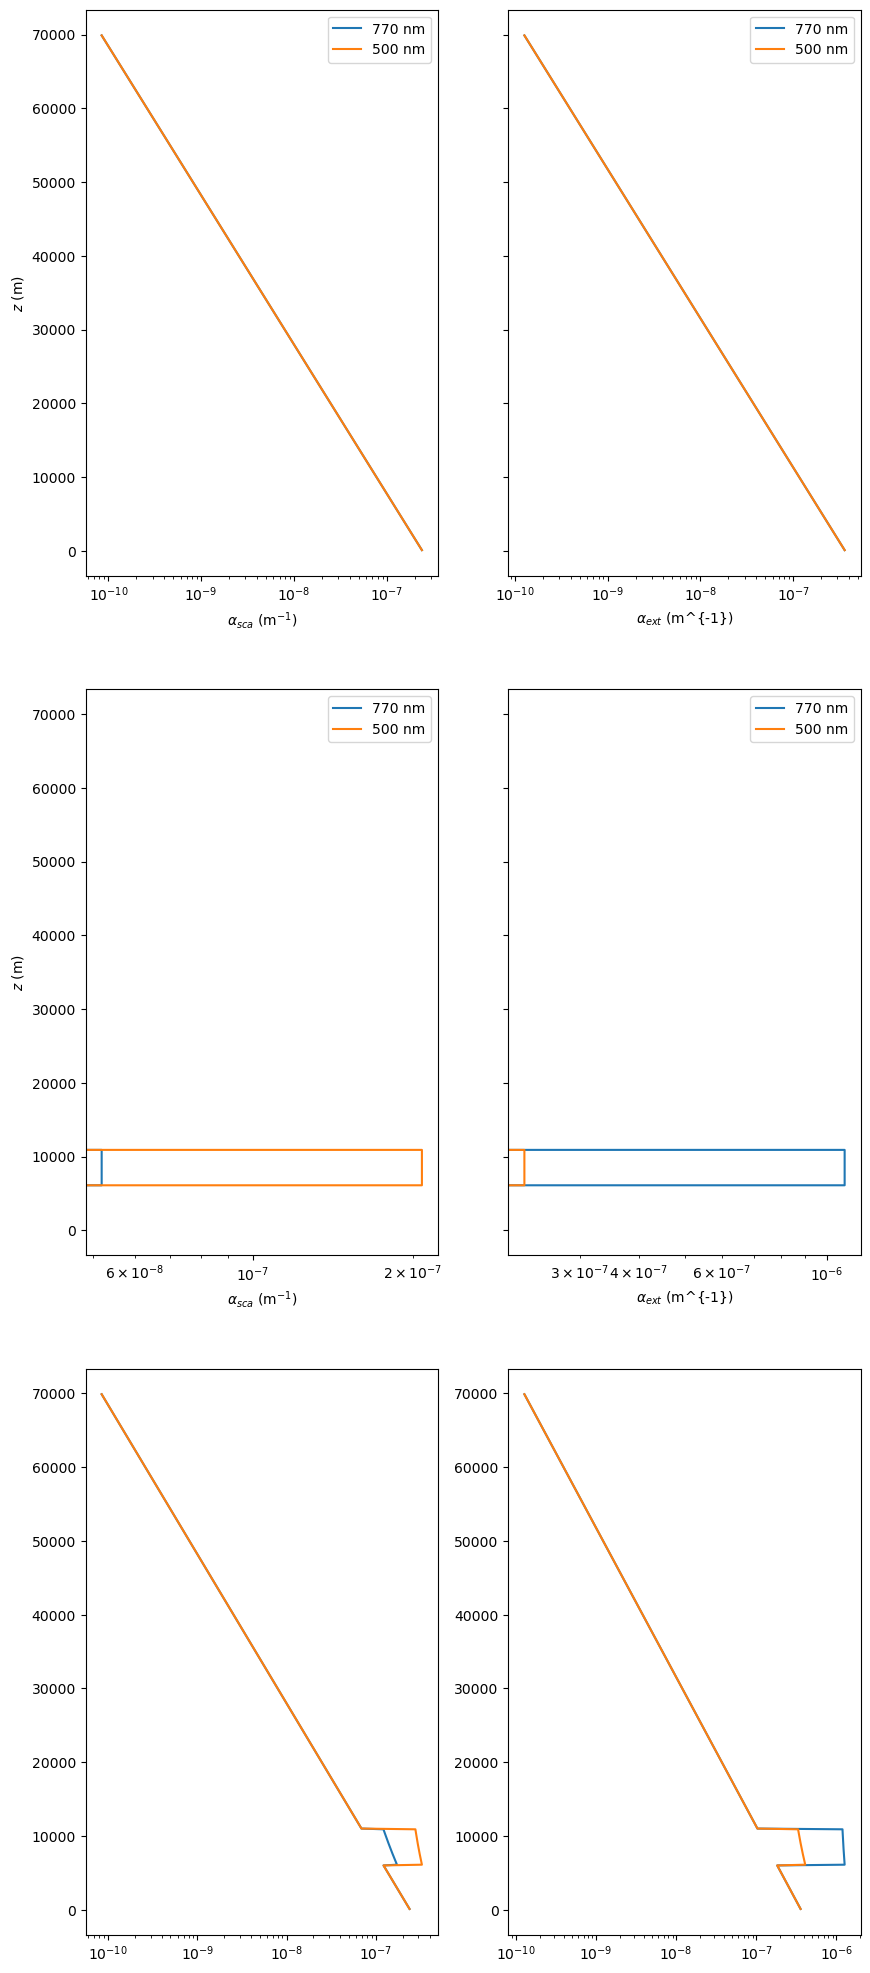

In [17]:
# plotting all the parameters required...

fig = plt.figure(figsize=(10,25))

# we have two gases, each operating at two wavelengths. Want to consider absorption and extinction at both, for both gases, and combined...
# Row 1: (left) scattering for the two different wavelengths of gas 1; (right) extinction for the two different wavelengths of gas 1
# Row 2: same but for gas 2 (Aero)
# Row 3: (left) combined scattering for the gases in both wavelengths; (right) combined extinction for the two gases in both wavelengths.

gases = [GG,Aero]
for row,g in enumerate(gases):
    ax = fig.add_subplot(3,2,row*2 + 1)
    for i,l in enumerate(lambdas):
        betaZ = g.n_z * np.sum(g.csSca[i,:])
        ax.plot(betaZ,z,label='{} nm'.format(l))
    ax.set_ylabel(r'$z$ (m)')
    ax.set_xlabel(r'$\alpha_{sca}$ (m$^{-1}$)')
    ax.legend()
    ax.set_xscale('log')

    ax = fig.add_subplot(3,2,row*2 + 2)
    for i,l in enumerate(lambdas):
        betaZ = g.n_z * g.csExt[i,i]
        ax.plot(betaZ,z,label='{} nm'.format(l))
    ax.set_yticklabels([])
    ax.set_xlabel(r'$\alpha_{ext}$ (m^{-1})')
    ax.legend()
    ax.set_xscale('log')

ax = fig.add_subplot(3,2,5)
for i,l in enumerate(lambdas):
    betaZ = betaZ * 0
    for g in gases:
        betaZ += g.n_z * np.sum(g.csSca[i,:])
    ax.plot(betaZ,z,label='{} nm'.format(l))
ax.set_xscale('log')

ax = fig.add_subplot(3,2,6)
for i,l in enumerate(lambdas):
    betaZ = betaZ * 0
    for g in gases:
        betaZ += g.n_z * g.csExt[i,i]
    ax.plot(betaZ,z,label='{} nm'.format(l))
ax.set_xscale('log')
